
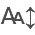

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import textwrap
import seaborn as sns
import missingno as msno
from itables import show
from itables import init_notebook_mode
from scipy.stats import pearsonr
import json
import scipy.stats as stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MaxAbsScaler,
    MinMaxScaler,
    Normalizer,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    minmax_scale,
)
from sklearn.model_selection import train_test_split

# Set the maximum number of rows and columns displayed
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 250)

# Set options for itables
init_notebook_mode(all_interactive=True)

%matplotlib inline

To view interactive components from github, click this link:
https://nbviewer.org/github/deannachurch/SBCapstone_CRISPRScreens/blob/main/notebooks/FeatureProcessing.ipynb

# Feature Engineering

This is Capstone 2 - Pre-processing and Training Data Development. 

Rubric:
* create dummy features
* Scale/standardization
* Split data into train/test subsets

Note: Some normalization/standardization was done in the previous notebook. This was converting raw sequence counts to 'counts per millsion' (CPM)- this helps to normalize counts from different sequencing runs as depth of sequence can impact guide counts. 

# Process

1. Read the data from the brunello_normed_data.csv. This has gene level data, Tx level data and count data from two libraries. 
    1. There are two library counts in here, trac1 and trac2. 
    2. Let's initially just train the model on trac2 (more replicates) but then also apply to trac 1
2. Target variable is 'Annotation' (Essential, Non-Essential, Uncategorized)
    1. This is highly imbalanced data- most things are uncategorized.
3. Will create features for most things. From a biological perspective, many of these won't seem relevant, though in some cases they may pull out technical issues in the protocols. T

This is a categorization problem, so we will want a classifier. 


To test (later):

* XGBoost
* Random Forest


In [3]:
full_df=pd.read_csv('../data/processed/brunello_normed_data.csv')
full_df.sort_values('Target Gene ID', inplace=True, ascending=False)
show(full_df.head())

In [4]:
#define cols and order for new dataframes, dropping some columns
#removing raw counts
gene_cols=['Target Gene ID', 'Target Gene Symbol', 'Target Transcript', 'Genomic Sequence', 'Strand', 'sgRNA Target Sequence', 'PAM Sequence', 'Target Exon', 'Rule Set 2 score', 'Tx Length',
           'Gene Isoform Count', 'Gene Length', 'A375 mean', 'A375 median', 'A375 std_dev', "LOEUF", 'Annotation']
trac1_cols=['sgRNA Sequence', 'trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac1_RepB_CPM']
trac2_cols=['sgRNA Sequence', 'trac2_pDNA_CPM', 'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM']

trac1_df_cols=trac1_cols + gene_cols
trac2_df_cols=trac2_cols + gene_cols

print(trac1_df_cols)
print(trac2_df_cols)

['sgRNA Sequence', 'trac1_pDNA_CPM', 'trac1_RepA_CPM', 'trac1_RepB_CPM', 'Target Gene ID', 'Target Gene Symbol', 'Target Transcript', 'Genomic Sequence', 'Strand', 'sgRNA Target Sequence', 'PAM Sequence', 'Target Exon', 'Rule Set 2 score', 'Tx Length', 'Gene Isoform Count', 'Gene Length', 'A375 mean', 'A375 median', 'A375 std_dev', 'LOEUF', 'Annotation']
['sgRNA Sequence', 'trac2_pDNA_CPM', 'trac2_RepA_CPM', 'trac2_RepB_CPM', 'trac2_RepC_CPM', 'Target Gene ID', 'Target Gene Symbol', 'Target Transcript', 'Genomic Sequence', 'Strand', 'sgRNA Target Sequence', 'PAM Sequence', 'Target Exon', 'Rule Set 2 score', 'Tx Length', 'Gene Isoform Count', 'Gene Length', 'A375 mean', 'A375 median', 'A375 std_dev', 'LOEUF', 'Annotation']


In [5]:
#create new dataframes
trac1_df=full_df[trac1_df_cols]
trac2_df=full_df[trac2_df_cols]

print(f"Full df shape: {full_df.shape}")
print(f"Trac1 df shape: {trac1_df.shape}")
print(f"Trac2 df shape: {trac2_df.shape}")

Full df shape: (77449, 34)
Trac1 df shape: (77449, 21)
Trac2 df shape: (77449, 22)


# Gene level aggregation

We are trying to build a predictor that can predict whether a gene is 'essential' or not. The above dataframe has 4 lines per gene (in general) + 1000 non-targeting controls (which should represent neutrality- or drift). We will agreegrate these to one line per gene. 

In [6]:
# Group by 'Target Gene ID' and aggregate the count columns
# dropping some columns that won't be relevant for model building
# 'Target Gene Symbol', 'Target Transcript' 'Genomic Sequence'
aggregated_trac1_df = trac1_df.groupby('Target Gene ID').agg({
    'trac1_pDNA_CPM': ['mean', 'median', 'std'],
    'trac1_RepA_CPM': ['mean', 'median', 'std'],
    'trac1_RepB_CPM': ['mean', 'median', 'std'],
    'Target Exon': 'min',
    'Tx Length': 'first',
    'Gene Isoform Count': 'first',
    'Gene Length': 'first',
    'A375 mean': 'first',
    'A375 median': 'first',
    'A375 std_dev': 'first',
    'LOEUF': 'first',
    'Annotation': 'first'
}).reset_index()

# Flatten the MultiIndex columns
aggregated_trac1_df.columns = ['_'.join(col).strip('_').replace('_first', '') for col in aggregated_trac1_df.columns.values]

show(aggregated_trac1_df.head(20))

In [7]:
#need to fill in the NaN for non-targeting guide row on Target Exon_min
aggregated_trac1_df['Target Exon_min']=aggregated_trac1_df['Target Exon_min'].fillna(0)

In [8]:
# Group by 'Target Gene ID' and aggregate the count columns
aggregated_trac2_df = trac2_df.groupby('Target Gene ID').agg({
    'trac2_pDNA_CPM': ['mean', 'median', 'std'],
    'trac2_RepA_CPM': ['mean', 'median', 'std'],
    'trac2_RepB_CPM': ['mean', 'median', 'std'],
    'trac2_RepC_CPM': ['mean', 'median', 'std'],
    'Target Exon': 'min',
    'Tx Length': 'first',
    'Gene Isoform Count': 'first',
    'Gene Length': 'first',
    'A375 mean': 'first',
    'A375 median': 'first',
    'A375 std_dev': 'first',
    'LOEUF': 'first',
    'Annotation': 'first'
}).reset_index()

# Flatten the MultiIndex columns
aggregated_trac2_df.columns = ['_'.join(col).strip('_').replace('_first', '') for col in aggregated_trac2_df.columns.values]

show(aggregated_trac2_df.head(20))

In [9]:
aggregated_trac2_df['Target Exon_min']=aggregated_trac2_df['Target Exon_min'].fillna(0)

In [9]:
show(aggregated_trac2_df.head())

In [10]:
aggregated_trac1_df.to_csv('../data/processed/brunello_trac1_gene_level_data.csv', index=False)
aggregated_trac2_df.to_csv('../data/processed/brunello_trac2_gene_level_data.csv', index=False)

# Do splits

Initial library normalization is done (as this has to be done at the library level). Doing split now to try to avoid any data leakage. 

Question: Is this correct?

In [10]:
# Create a new dataframe without the 'Annotation' column
trac2_X = aggregated_trac2_df.drop(columns=['Annotation'])

# Create a separate dataframe for the 'Annotation' column
trac2_y = aggregated_trac2_df[['Annotation']]

show(trac2_X.head())
show(trac2_y.head())

In [11]:
# do split
trac2_X_train, trac2_X_test, trac2_y_train, trac2_y_test = train_test_split(trac2_X, trac2_y, test_size=0.2, random_state=42)

print(f"X train: {trac2_X_train.shape}")
print(f"X test: {trac2_X_test.shape}")

print(f"Annotation full: {aggregated_trac2_df['Annotation'].value_counts()}")
print(f"Annotation split (train): {trac2_y_train['Annotation'].value_counts()}")
print(f"Annotation split (test) {trac2_y_test['Annotation'].value_counts()}")

X train: (15292, 21)
X test: (3823, 21)
Annotation full: Annotation
Uncategorized    18050
NonEssential       858
Essential          207
Name: count, dtype: int64
Annotation split (train): Annotation
Uncategorized    14445
NonEssential       675
Essential          172
Name: count, dtype: int64
Annotation split (test) Annotation
Uncategorized    3605
NonEssential      183
Essential          35
Name: count, dtype: int64


# Feature engineering

1. Calculate quartiles for mean counts
2. Calculate quartiles for mean expression
3. calculate transcript length/exon number
4. calculate gene length/exon number
5. calculate gene length/transcript length


# Functions


In [12]:
def calculate_tiles(df, bin_no, count_cols):
    """
    Calculate appropriate 'tile' (quartile, decile, etc) for a count column in a dataframe.

    Parameters:
        df (pd.DataFrame): dataframe on which to operate
        bin_no (int): number of tiles to produce (4 for quartile, 10 for decile, etc)
        count_cols (list): 
    
    Returns:
        pd.DataFrame: The dataframe with the added 'tile' column
    """
    # Data validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df should be a pandas DataFrame")
    if not isinstance(count_cols, list):
        raise TypeError("count_cols should be a list")
    if not all(pd.api.types.is_numeric_dtype(df[col]) for col in count_cols):
        raise TypeError("All elements in count_cols should be numeric")

    if bin_no == 4:
        suffix="quartile"
    elif bin_no == 10:
        suffix="decile"
    else:
        suffix=f"{bin_no}_tile"
    
    for count_col in count_cols:
        new_col=f'{count_col}_{suffix}'
        df[new_col] = pd.qcut(df[count_col], bin_no, labels=False) + 1 

    return df

In [13]:
def calculate_ratio(df, num, denom, name):
    """ 
    Calculate the ratio of two columns in a dataframe

    Parameters: 
        df (pd.DataFrame): dataframe on which to operate
        num: column name of the numerator
        denom: column name of the denominator
        name: name of new column

    Returns:
        pd.DataFrame: Updated dataframe with the added ratio column
    """
    # Data validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df should be a pandas DataFrame")
    if num not in df.columns:
        raise KeyError(f"{num} not a column name in df")
    if denom not in df.columns:
        raise KeyError(f"{denom} not a column name in df")
    if not pd.api.types.is_numeric_dtype(df[num]):
        raise TypeError(f"num column is not numeric")
    if not pd.api.types.is_numeric_dtype(df[denom]):
        raise TypeError(f"denom column is not numeric")
    
    df[name] = df[num]/df[denom]

    return df

In [14]:
def dist_plots(df, col_list):
    """ 
    dist_plots 
    take a dataframe and a column list
    Plot the distributions for that columns

    return the figure
    """
    # Calculate the number of rows and columns needed for the subplots
    num_cols = 4  # You can adjust this number based on your preference
    num_rows = len(col_list) // num_cols + (1 if len(col_list) % num_cols > 0 else 0)

    # Create a figure with subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axs = axs.flatten()  # Flatten the array for easy iteration

    for i, col in enumerate(col_list):
        if not pd.api.types.is_numeric_dtype(df[col]):
            print(f"The column {col} is not numeric, skipping col.")
            continue
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'Distribution of {col}')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    return fig

In [15]:
trac2_X_train=calculate_tiles(trac2_X_train, 4, ['trac2_pDNA_CPM_mean', 'trac2_RepA_CPM_mean', 'trac2_RepB_CPM_mean', 'trac2_RepC_CPM_mean', 'A375 mean'])
trac2_X_test=calculate_tiles(trac2_X_test, 4, ['trac2_pDNA_CPM_mean', 'trac2_RepA_CPM_mean', 'trac2_RepB_CPM_mean', 'trac2_RepC_CPM_mean', 'A375 mean'])

show(trac2_X_train.head())

In [16]:
trac2_X_train=calculate_ratio(trac2_X_train, 'Tx Length', 'Target Exon_min', 'TargetEx2TxLength')
trax2_X_test=calculate_ratio(trac2_X_test, 'Tx Length', 'Target Exon_min', 'TargetEx2TxLength')
trac2_X_train=calculate_ratio(trac2_X_train, 'Gene Length', 'Target Exon_min', 'TargetEx2GeneLength')
trac2_X_test=calculate_ratio(trac2_X_test, 'Gene Length', 'Target Exon_min', 'TargetEx2GeneLength')
trac2_X_train=calculate_ratio(trac2_X_train, 'Gene Length', 'Tx Length', 'Gene2TxLength')
trac2_X_test=calculate_ratio(trac2_X_test, 'Gene Length', 'Tx Length', 'Gene2TxLength')
#add other ratios
show(trac2_X_train.head())
show(trax2_X_test.head())

In [17]:
# Convert all columns ending in _quartile to category
quartile_cols = [col for col in trac2_X_train.columns if col.endswith('_quartile')]
trac2_X_train[quartile_cols] = trac2_X_train[quartile_cols].astype('category')

quartile_cols = [col for col in trac2_X_test.columns if col.endswith('_quartile')]
trac2_X_test[quartile_cols] = trac2_X_test[quartile_cols].astype('category')

# Verify the changes
trac2_X_train.dtypes

Target Gene ID                     int64
trac2_pDNA_CPM_mean              float64
trac2_pDNA_CPM_median            float64
trac2_pDNA_CPM_std               float64
trac2_RepA_CPM_mean              float64
trac2_RepA_CPM_median            float64
trac2_RepA_CPM_std               float64
trac2_RepB_CPM_mean              float64
trac2_RepB_CPM_median            float64
trac2_RepB_CPM_std               float64
trac2_RepC_CPM_mean              float64
trac2_RepC_CPM_median            float64
trac2_RepC_CPM_std               float64
Target Exon_min                  float64
Tx Length                        float64
Gene Isoform Count               float64
Gene Length                      float64
A375 mean                        float64
A375 median                      float64
A375 std_dev                     float64
LOEUF                            float64
trac2_pDNA_CPM_mean_quartile    category
trac2_RepA_CPM_mean_quartile    category
trac2_RepB_CPM_mean_quartile    category
trac2_RepC_CPM_mean_quartile    category
A375 mean_quartile              category
TargetEx2TxLength                float64
TargetEx2GeneLength              float64
Gene2TxLength                    float64
dtype: object

In [18]:
trac2_X_test.dtypes

Target Gene ID                     int64
trac2_pDNA_CPM_mean              float64
trac2_pDNA_CPM_median            float64
trac2_pDNA_CPM_std               float64
trac2_RepA_CPM_mean              float64
trac2_RepA_CPM_median            float64
trac2_RepA_CPM_std               float64
trac2_RepB_CPM_mean              float64
trac2_RepB_CPM_median            float64
trac2_RepB_CPM_std               float64
trac2_RepC_CPM_mean              float64
trac2_RepC_CPM_median            float64
trac2_RepC_CPM_std               float64
Target Exon_min                  float64
Tx Length                        float64
Gene Isoform Count               float64
Gene Length                      float64
A375 mean                        float64
A375 median                      float64
A375 std_dev                     float64
LOEUF                            float64
trac2_pDNA_CPM_mean_quartile    category
trac2_RepA_CPM_mean_quartile    category
trac2_RepB_CPM_mean_quartile    category
trac2_RepC_CPM_mean_quartile    category
A375 mean_quartile              category
TargetEx2TxLength                float64
TargetEx2GeneLength              float64
Gene2TxLength                    float64
dtype: object

# Scaling/Transforming/Normalizing

Looking at various columns to see what is the best way to standardize/normalize

Because I suspect different columns may need different standardization, I will subest dataframes to investigate various approaches. 

Will use ColumnTransformer in the end to do the final transformation 

Remember: use the 'train' scaler to also scale the 'test' data. 


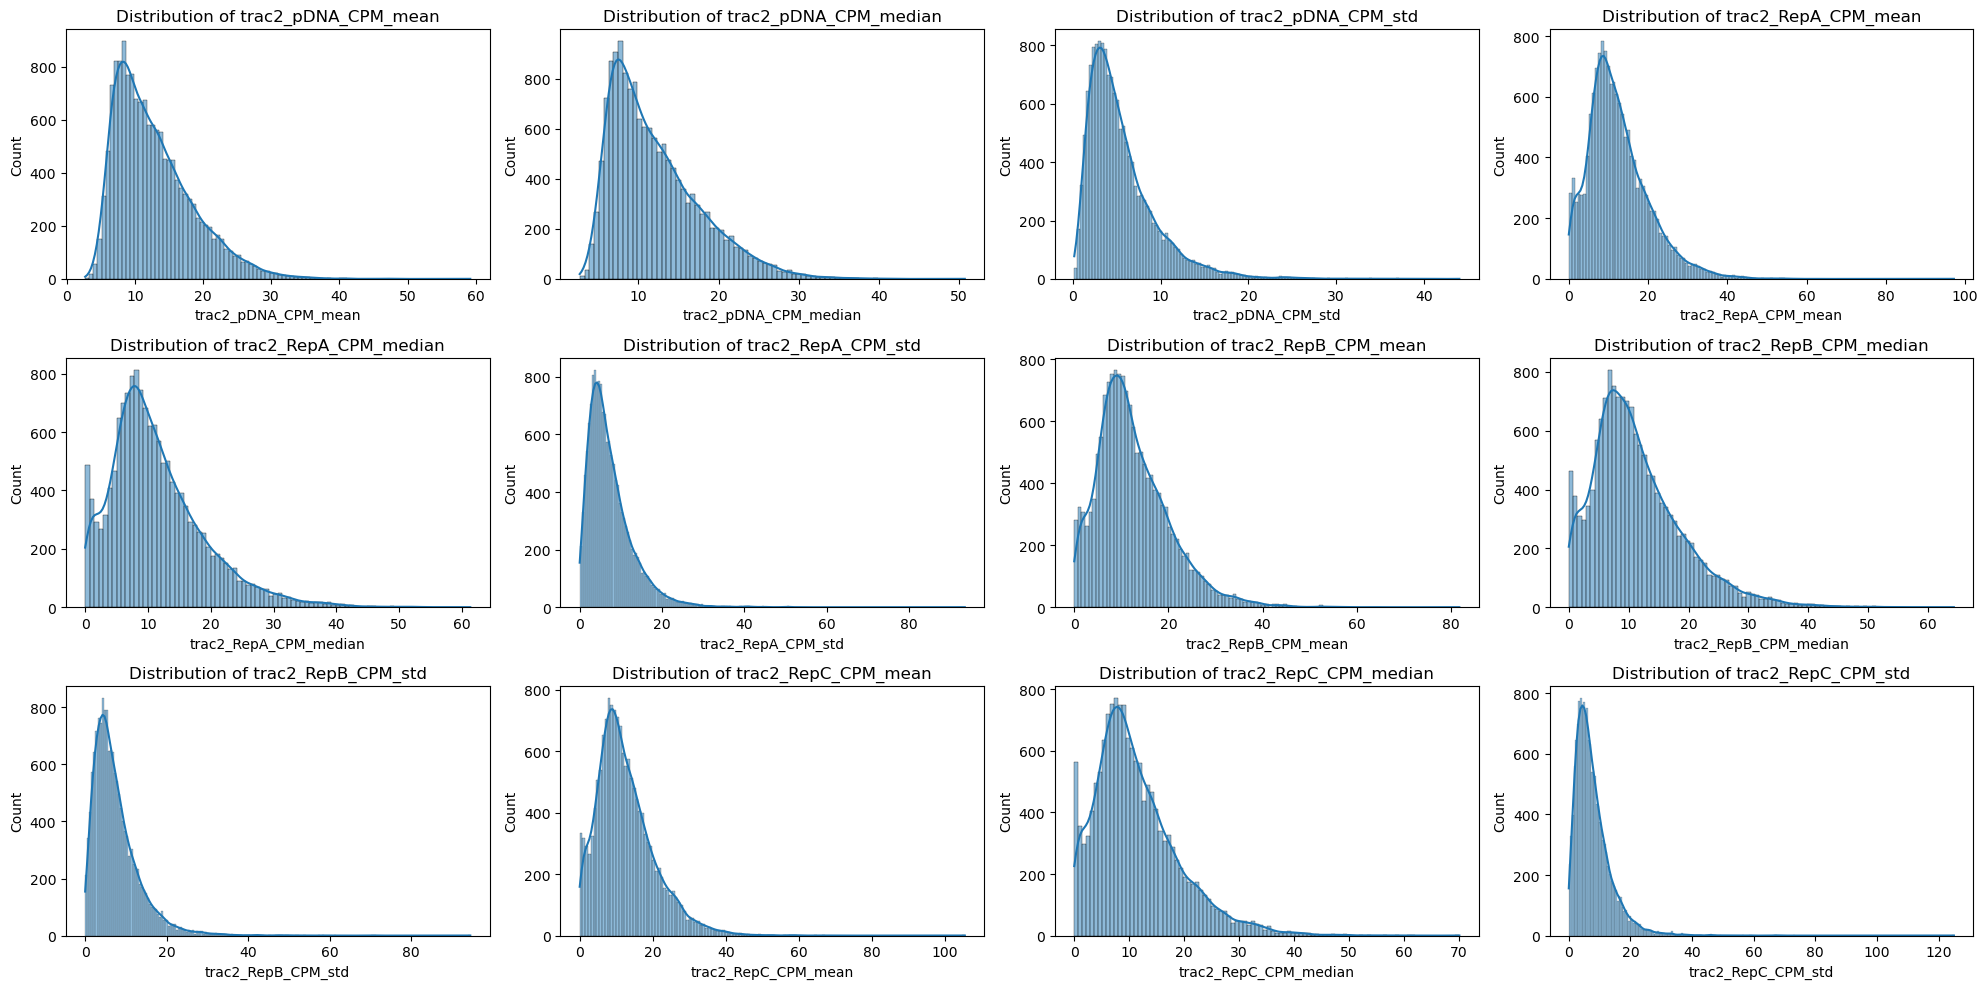

In [19]:
# count columns

count_cols=['trac2_pDNA_CPM_mean', 'trac2_pDNA_CPM_median', 'trac2_pDNA_CPM_std', 'trac2_RepA_CPM_mean', 'trac2_RepA_CPM_median', 'trac2_RepA_CPM_std', 
            'trac2_RepB_CPM_mean', 'trac2_RepB_CPM_median', 'trac2_RepB_CPM_std', 'trac2_RepC_CPM_mean', 'trac2_RepC_CPM_median', 'trac2_RepC_CPM_std']

fig=dist_plots(trac2_X_train, count_cols)
plt.show()

In [20]:
#based on information here, I'm going to try a box-cox transformation using PowerScaler
#will in initially pull out columns to test different transformations, but will use ColumnTransformer on the final dataframe
count_df=trac2_X_train[count_cols]
show(count_df.head())

In [21]:
for col in count_df.columns:
    print(f"Column: {col}, Shape: {count_df[col].shape}")

Column: trac2_pDNA_CPM_mean, Shape: (15292,)
Column: trac2_pDNA_CPM_median, Shape: (15292,)
Column: trac2_pDNA_CPM_std, Shape: (15292,)
Column: trac2_RepA_CPM_mean, Shape: (15292,)
Column: trac2_RepA_CPM_median, Shape: (15292,)
Column: trac2_RepA_CPM_std, Shape: (15292,)
Column: trac2_RepB_CPM_mean, Shape: (15292,)
Column: trac2_RepB_CPM_median, Shape: (15292,)
Column: trac2_RepB_CPM_std, Shape: (15292,)
Column: trac2_RepC_CPM_mean, Shape: (15292,)
Column: trac2_RepC_CPM_median, Shape: (15292,)
Column: trac2_RepC_CPM_std, Shape: (15292,)


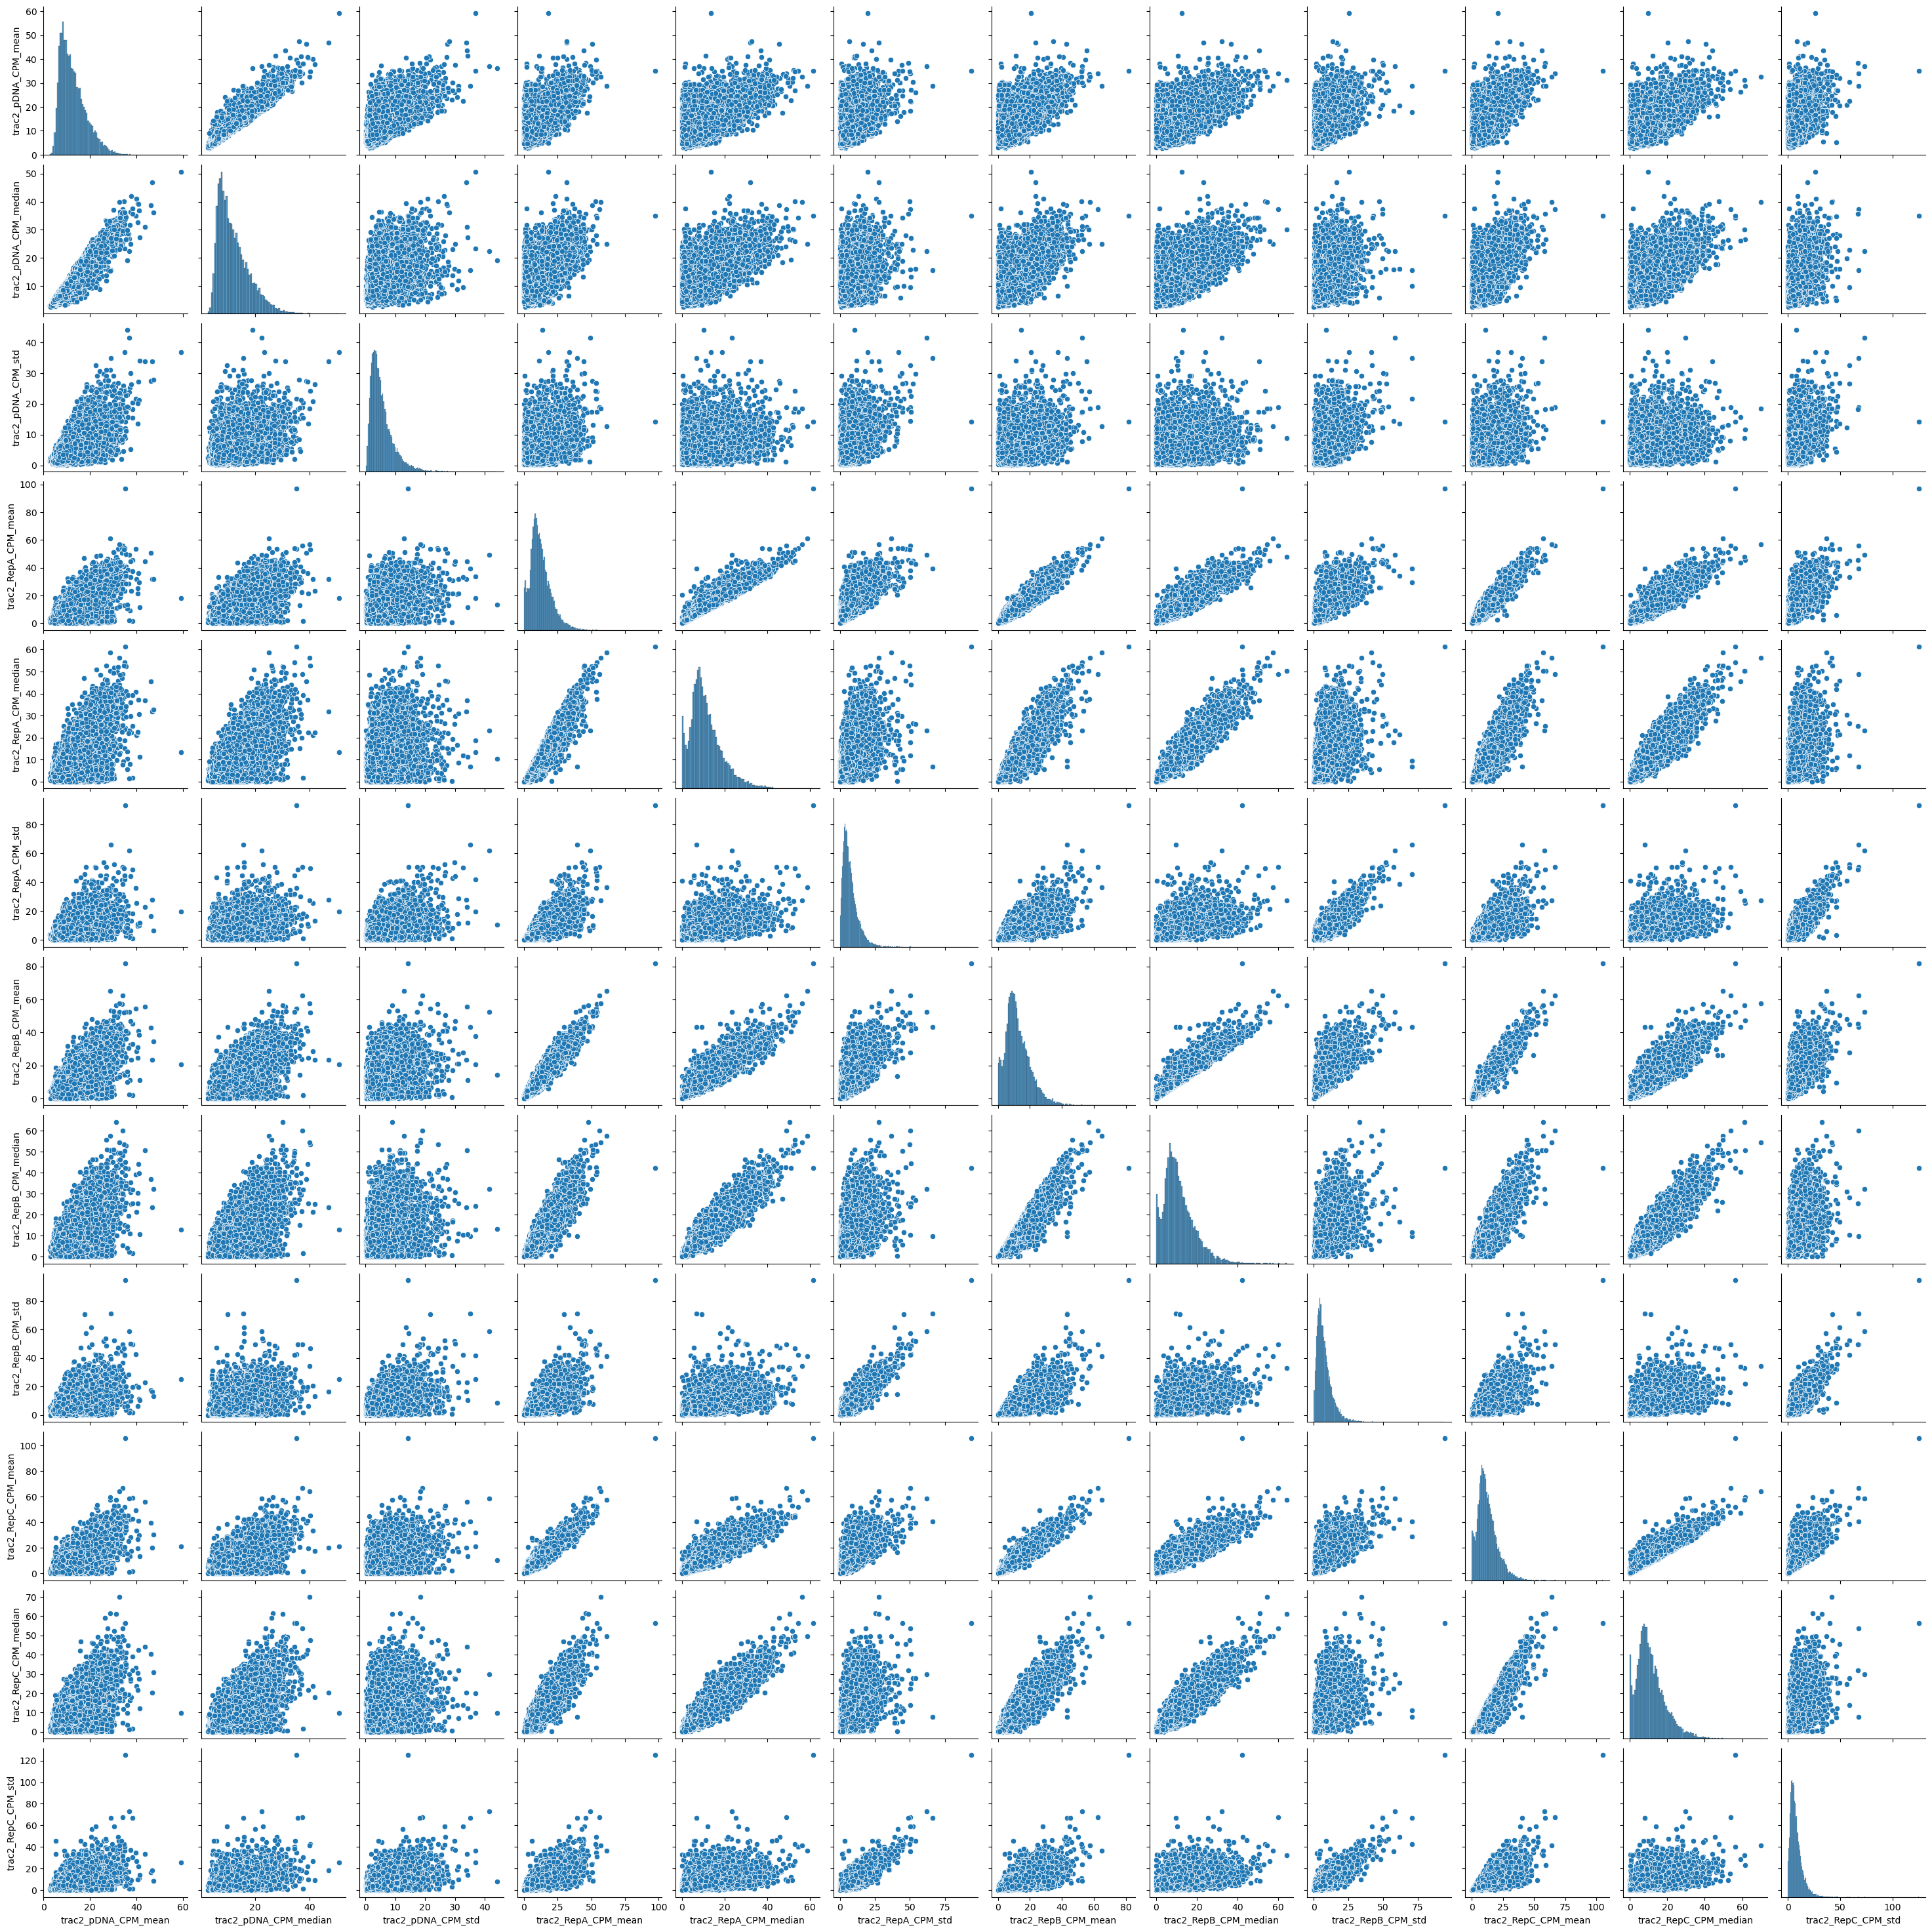

In [22]:
sns.pairplot(count_df)
plt.show()

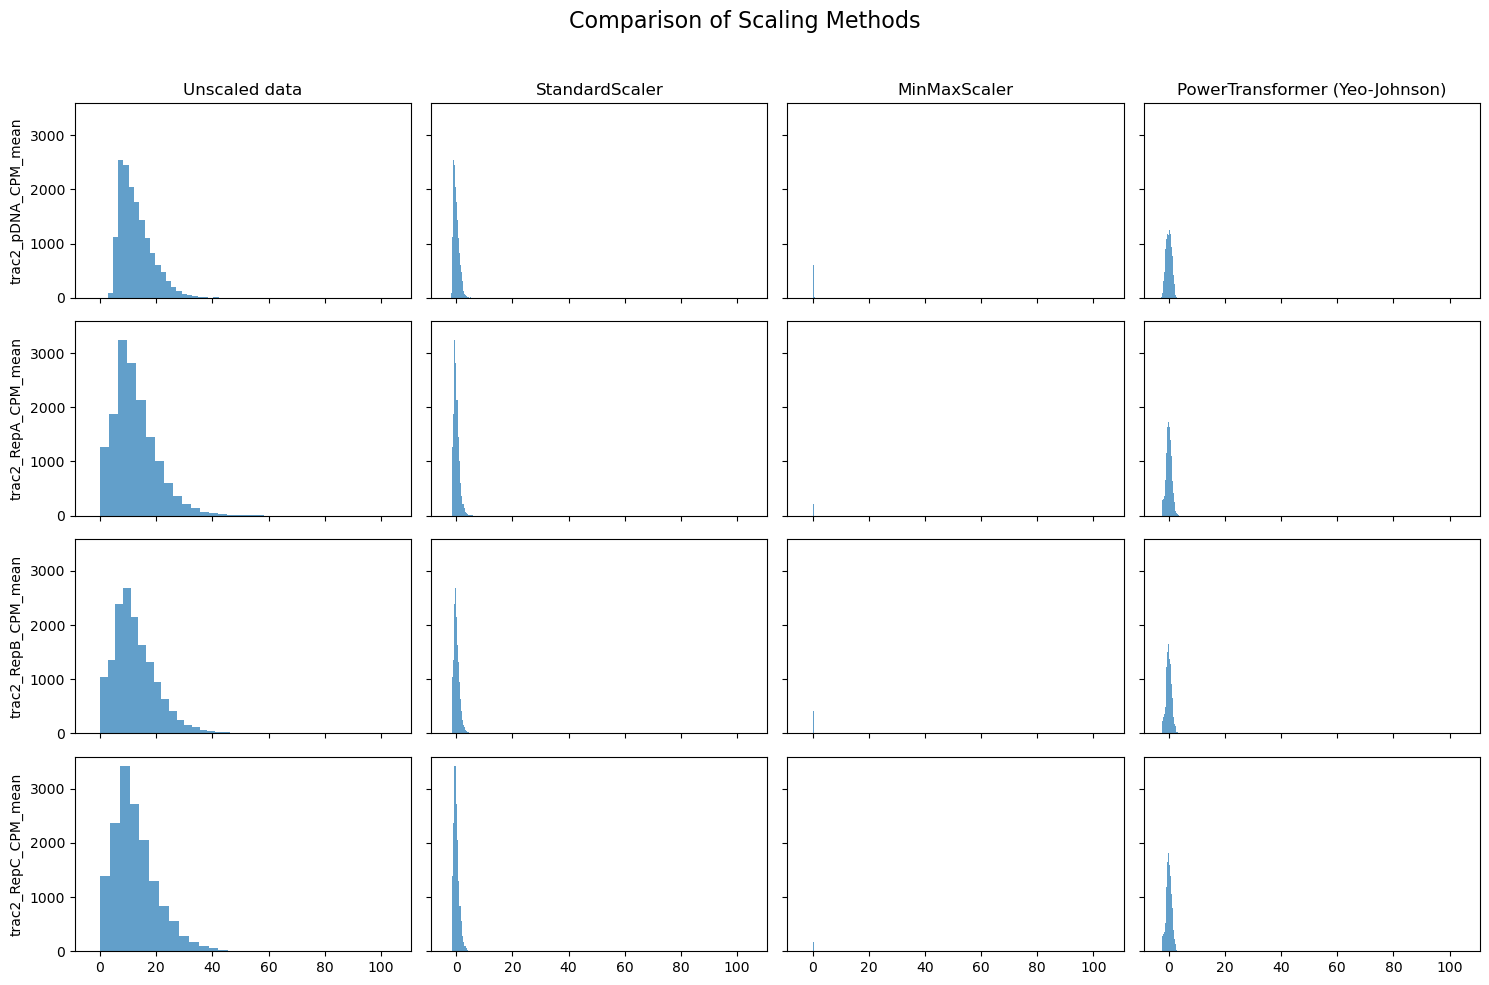

In [23]:
#adapted from https://scikit-learn.org/1.5/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
#systematic check of all scaling approaches

#lets just take a subset of features to make visualization easier- we'll just do count means

features=['trac2_pDNA_CPM_mean', 'trac2_RepA_CPM_mean', 'trac2_RepB_CPM_mean', 'trac2_RepC_CPM_mean']

# Define the scalers
scalers = {
    "Unscaled data": None,
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "PowerTransformer (Yeo-Johnson)": PowerTransformer(method="yeo-johnson"),
}

# Apply the scalers and store the results
scaled_data = {}
for name, scaler in scalers.items():
    if scaler is not None:
        scaled_data[name] = scaler.fit_transform(count_df[features])
    else:
        scaled_data[name] = count_df[features].values

# Plot the original and scaled data side by side
fig, axes = plt.subplots(len(features), len(scalers), figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Comparison of Scaling Methods', fontsize=16)

for i, feature in enumerate(features):
    for j, (name, data) in enumerate(scaled_data.items()):
        axes[i, j].hist(data[:, i], bins=30, alpha=0.7)
        if i == 0:
            axes[i, j].set_title(name)
        if j == 0:
            axes[i, j].set_ylabel(feature)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




# count scaling
use PowerTransformer (yeo-johnson is default)

the mean, median and std have the same rough distribution, so will use this scaling on all of them. 

# Gene/Transcript attributes

Plot distributions for these and figure out if you need to scale/normalize

In [24]:
trac2_X_train.columns

Index(['Target Gene ID', 'trac2_pDNA_CPM_mean', 'trac2_pDNA_CPM_median',
       'trac2_pDNA_CPM_std', 'trac2_RepA_CPM_mean', 'trac2_RepA_CPM_median',
       'trac2_RepA_CPM_std', 'trac2_RepB_CPM_mean', 'trac2_RepB_CPM_median',
       'trac2_RepB_CPM_std', 'trac2_RepC_CPM_mean', 'trac2_RepC_CPM_median',
       'trac2_RepC_CPM_std', 'Target Exon_min', 'Tx Length',
       'Gene Isoform Count', 'Gene Length', 'A375 mean', 'A375 median',
       'A375 std_dev', 'LOEUF', 'trac2_pDNA_CPM_mean_quartile',
       'trac2_RepA_CPM_mean_quartile', 'trac2_RepB_CPM_mean_quartile',
       'trac2_RepC_CPM_mean_quartile', 'A375 mean_quartile',
       'TargetEx2TxLength', 'TargetEx2GeneLength', 'Gene2TxLength'],
      dtype='object')

In [25]:
gene_columns=['Target Exon_min', 'Tx Length', 'Gene Isoform Count', 'Gene Length', 
              'TargetEx2TxLength', 'TargetEx2GeneLength', 'Gene2TxLength']
gene_df=trac2_X_train[gene_columns]
show(gene_df.head())

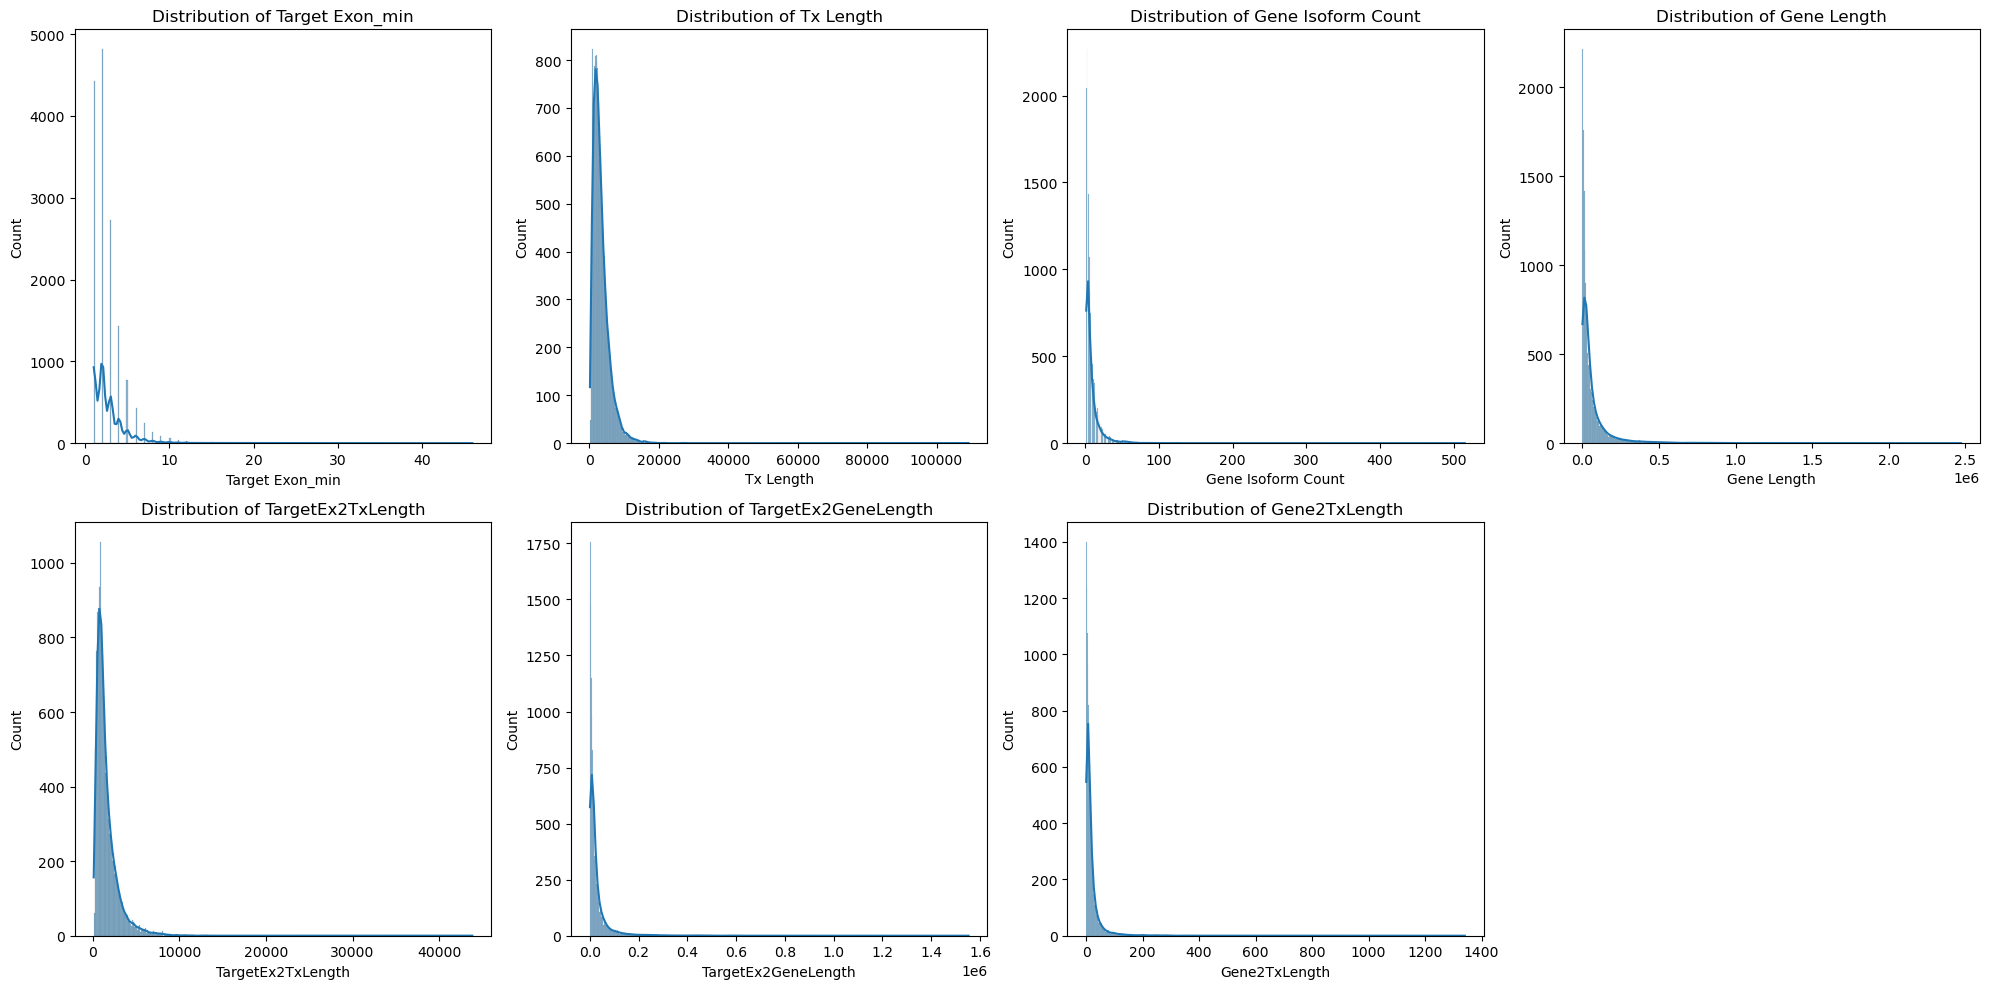

In [26]:
fig=dist_plots(gene_df, gene_columns)
plt.show()

# Distribution shapes look similar to count data.

Will also use the PowerTransformer on these data.


# Final feature engineering dataframe

* Use PowerTransformer (yeo-johnson) to scale measurement/count data
* Use get_dummies() on the categorical variables
    + Note: I'm not sure I really need to do this for a classifier. 

* Other questions
    + can the 'label' dataframe have >1 column? For example, should I put the GeneID here?
    + should I remove the gene id from the X dataframe?


In [27]:
trac2_X_train_dummies=pd.get_dummies(trac2_X_train)

pt=PowerTransformer(method='yeo-johnson')
pt.fit(trac2_X_train_dummies)
scaled_data=pt.transform(trac2_X_train_dummies)

print(scaled_data)

[[-1.32740005  0.57994087  0.82866159 ... -0.59547709 -0.55922331
   1.73205081]
 [ 0.49865079 -1.03164297 -0.75331204 ... -0.59547709 -0.55922331
  -0.57735027]
 [ 1.07295597 -1.82201484 -1.6661793  ... -0.59547709  1.78819443
  -0.57735027]
 ...
 [-0.6087794   0.31644637  0.42392409 ...  1.67932573 -0.55922331
  -0.57735027]
 [-1.66232377  1.1135839   0.75596084 ... -0.59547709 -0.55922331
  -0.57735027]
 [ 0.8131705   2.1968159   1.93177992 ...  1.67932573 -0.55922331
  -0.57735027]]


In [28]:
trac2_X_test_dummies=pd.get_dummies(trac2_X_test)
scaled_test_data=pt.transform(trac2_X_test_dummies)
print(scaled_test_data)

[[ 0.66993039 -0.82391258 -0.60223235 ... -0.59547709 -0.55922331
   1.73205081]
 [ 0.2925174   1.32507714  1.37334383 ... -0.59547709 -0.55922331
   1.73205081]
 [-0.03267359 -0.24850679 -0.20462882 ... -0.59547709 -0.55922331
   1.73205081]
 ...
 [ 0.78179579  0.46908825 -0.07477065 ... -0.59547709 -0.55922331
  -0.57735027]
 [ 0.32930467 -1.6440395  -1.74597092 ... -0.59547709 -0.55922331
   1.73205081]
 [-1.14152539 -0.71437309 -0.43104799 ... -0.59547709 -0.55922331
   1.73205081]]
